In [2]:
import glob
import mne
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import numpy as np

# Download fsaverage files
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in C:\Users\work\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage


In [4]:
labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                            subjects_dir=subjects_dir, verbose=False)
labels.pop(-1) # remove the unknown label
label_names = [label.name for label in labels]

In [5]:
lobe_map = {"Frontal":{
                "frontalpole":"FP",
                "medialorbitofrontal":"MO",
                "lateralorbitofrontal":"LO",
                "paracentral":"ParaC",
                "parsopercularis":"POp",
                "parsorbitalis":"POr",
                "parstriangularis":"PT",
                "precentral": "PreC",
                "rostralanteriorcingulate":"RAC",
                "rostralmiddlefrontal":"RMF",
                "superiorfrontal":"SF",
                "caudalanteriorcingulate":"CACC",
                "caudalmiddlefrontal":"CMF",
            },
            "Parietal":{
                "superiorparietal":"SP",
                "inferiorparietal":"IP",
                "isthmuscingulate":"IC",
                "postcentral":"PG",
                "posteriorcingulate":"PCC",
                "precuneus":"PCUN",
                "supramarginal":"SG",
            },
            "Temporal":{
                "bankssts":"BSTS",
                "entorhinal":"ENT",
                "fusiform":"FUS",
                "middletemporal":"MT",
                "parahippocampal":"PHG",
                "superiortemporal": "STG",
                "temporalpole":"TP",
                "transversetemporal":"TTG",
                "inferiortemporal":"ITG",
            },
            "Occipital":{
                "cuneus":"CUN",
                "lateraloccipital":"LOC",
                "lingual":"LNG",
                "pericalcarine":"PCAL",
            },
            "Insula":{
                "insula":"INS"
            }
}
lobe_map_color = {"Frontal": (1,0,0),
                  "Insula": (0,1,0),
                "Temporal": (0,0,1),
                "Parietal": (1, 1,0), 
                 "Occipital": (0,1,1),
}

In [6]:
# params
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                            subjects_dir=subjects_dir, verbose=False)
labels.pop(-1) # remove the unknown label
label_names = [label.name for label in labels]

# all functions
# example 1_al_ciplv_theta_1.npy
def parse_filename(filename):
    s = filename.split("_")
    pId = s[0]
    label = s[1]
    method = s[2]
    freq = s[-1].split(".")[0]
    
    return {"pId": pId, "label": label, "method": method, "freq": freq}

def read_file(filename): 
    data = np.load(filename)
    return data

def read_file2(filename): # use for lobe-level
    data = np.load(filename)
    data = data + data.T - np.diag(data.diagonal())
    df_corr = pd.DataFrame(data, columns = label_names, index = label_names)
    df_pair = df_corr.stack().reset_index()
    df_pair.columns = ["source", "target", "value"]
    return df_pair

# get all the files in the folder output/
def get_files(folder, filter = None):
    '''
    filter is a dictionary, has 2 keys: method and freq to filter the files
    '''
    files = glob.glob(os.path.join(folder, "*.npy"))
    ret_files = []
    if filter:
        for f in files:
            # get the filename
            filename = os.path.basename(f)
            f_info = parse_filename(filename)
            # remove epoch 2 if no overlap
            # if f_info["epoch"] == "2":
            #     continue
            if (f_info["method"] == filter["method"]) and (f_info["freq"] == filter["freq"]):
                ret_files.append(f)
    else:
        ret_files = files

    return ret_files

def feature_extraction(data):
    """
    get lower part of diagonal matrix
    """
    data_lower = data[np.tril_indices(data.shape[0], k=-1)]
    return data_lower

def get_lobe(name):
    # get hemisphere and label
    label = name.split("-")[0]
    hemisphere = name.split("-")[1]

    for lobe in lobe_map:
        if label in lobe_map[lobe]:
            return lobe, hemisphere
    return None

def get_lobe2(name):
    # get hemisphere and label
    label = name.split("-")[0]
    hemisphere = name.split("-")[1]

    for lobe in lobe_map:
        if label in lobe_map[lobe]:
            return lobe
    return None

def feature_extraction_lobe_level(data):
    """
    data: pandas frame 3 columns: source, target, value. outputs from read_file2()
    """

    # get the lobe level using the lobe_map
    data["source_lobe"] = data["source"].apply(lambda x: get_lobe(x))
    data["target_lobe"] = data["target"].apply(lambda x: get_lobe(x))

    # average the value for the same lobe
    data = data.groupby(["source_lobe", "target_lobe"]).mean().reset_index()

    return data

0 files missing from root.txt in C:\Users\work\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage


In [7]:
lh_labels = ['lateraloccipital-lh','pericalcarine-lh','cuneus-lh','lingual-lh',
            'inferiorparietal-lh','superiorparietal-lh','precuneus-lh','isthmuscingulate-lh','supramarginal-lh','postcentral-lh','posteriorcingulate-lh',
            'bankssts-lh','fusiform-lh','inferiortemporal-lh','parahippocampal-lh','middletemporal-lh','transversetemporal-lh','superiortemporal-lh','entorhinal-lh','temporalpole-lh',
            'insula-lh',
            'paracentral-lh','precentral-lh','caudalmiddlefrontal-lh','parsopercularis-lh','caudalanteriorcingulate-lh','superiorfrontal-lh','lateralorbitofrontal-lh','parstriangularis-lh','rostralanteriorcingulate-lh','medialorbitofrontal-lh','parsorbitalis-lh','rostralmiddlefrontal-lh','frontalpole-lh']
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

new_order = []
new_order.extend(lh_labels[::-1])  # reverse the order
new_order.extend(rh_labels)

In [8]:
freqs = ['delta', 'theta', 'alpha', 'beta', 'gamma']
method = 'pli'
output_dir_prefix = "output/no_split"
# condition = "al"

In [9]:
al_sum = np.zeros((len(labels), len(labels)))
# get all the files
files = glob.glob(f"{output_dir_prefix}/*al*{method}*{freqs[0]}*.npy")
# print(files)
for file in files:
    al_sum += np.load(file)

al_sum = al_sum / len(files)

In [10]:
data = np.load("connection_alter_beta.npy")
df_corr = pd.DataFrame(data, columns = label_names, index = label_names)
df_order = df_corr.reindex(new_order, axis=0).reindex(new_order, axis=1)
(df_order>0).sum(axis=1)

frontalpole-lh                 0
rostralmiddlefrontal-lh        2
parsorbitalis-lh               1
medialorbitofrontal-lh         4
rostralanteriorcingulate-lh    3
                              ..
rostralanteriorcingulate-rh    3
medialorbitofrontal-rh         1
parsorbitalis-rh               5
rostralmiddlefrontal-rh        5
frontalpole-rh                 0
Length: 68, dtype: int64

In [11]:
c_increase = (df_order>0).sum(axis=1)
roi = c_increase.index[0]
for lobe in lobe_map:
    if roi.split("-")[0] in lobe_map[lobe]:
        print(roi,lobe)

frontalpole-lh Frontal


In [12]:
d_change = {}
for i, f in enumerate(freqs):
    data = np.load(f"connection_alter_{f}.npy")
    df_corr = pd.DataFrame(data, columns = label_names, index = label_names)
    df_order = df_corr.reindex(new_order, axis=0).reindex(new_order, axis=1)
    d_count_increase = {k:0 for k in lobe_map.keys()}
    d_count_decrease = {k:0 for k in lobe_map.keys()}

    c_increase = (df_order>0).sum(axis=1)
    c_decrease = (df_order<0).sum(axis=1)
    for k in range(len(c_increase)):
        roi = c_increase.index[k]
        for lobe in lobe_map:
            if roi.split("-")[0] in list(lobe_map[lobe].keys()):
                d_count_increase[lobe] += c_increase[k]
                break

    for k in range(len(c_decrease)):
        roi = c_decrease.index[k]
        for lobe in lobe_map:
            if roi.split("-")[0] in list(lobe_map[lobe].keys()):
                d_count_decrease[lobe] += c_decrease[k]
                break
    print(f)
    print("increase", d_count_increase, sum(d_count_increase.values()))
    print("decrease", d_count_decrease, sum(d_count_decrease.values()))
    d_change[f] = [d_count_increase, d_count_decrease]

    #convert to percentage
    d_count_increase = {k: round(v/sum(c_increase), 3) for k, v in d_count_increase.items()}
    d_count_decrease = {k: round(v/sum(c_decrease), 3) for k, v in d_count_decrease.items()}
    # print(f)
    print("increase", d_count_increase)
    print("decrease", d_count_decrease)
    # d_change[f] = [d_count_increase, d_count_decrease]

delta
increase {'Frontal': 49, 'Parietal': 42, 'Temporal': 30, 'Occipital': 11, 'Insula': 2} 134
decrease {'Frontal': 71, 'Parietal': 32, 'Temporal': 40, 'Occipital': 14, 'Insula': 5} 162
increase {'Frontal': 0.366, 'Parietal': 0.313, 'Temporal': 0.224, 'Occipital': 0.082, 'Insula': 0.015}
decrease {'Frontal': 0.438, 'Parietal': 0.198, 'Temporal': 0.247, 'Occipital': 0.086, 'Insula': 0.031}
theta
increase {'Frontal': 57, 'Parietal': 31, 'Temporal': 33, 'Occipital': 17, 'Insula': 2} 140
decrease {'Frontal': 48, 'Parietal': 54, 'Temporal': 35, 'Occipital': 19, 'Insula': 0} 156
increase {'Frontal': 0.407, 'Parietal': 0.221, 'Temporal': 0.236, 'Occipital': 0.121, 'Insula': 0.014}
decrease {'Frontal': 0.308, 'Parietal': 0.346, 'Temporal': 0.224, 'Occipital': 0.122, 'Insula': 0.0}
alpha
increase {'Frontal': 45, 'Parietal': 30, 'Temporal': 41, 'Occipital': 13, 'Insula': 3} 132
decrease {'Frontal': 59, 'Parietal': 56, 'Temporal': 36, 'Occipital': 11, 'Insula': 2} 164
increase {'Frontal': 0.341

c:\Users\work\Anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  


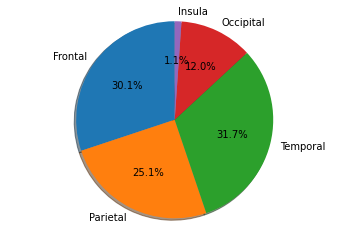

In [13]:
import matplotlib.pyplot as plt
# pie chart of beta
labels = list(d_count_increase.keys())
sizes = list(d_count_increase.values())

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [14]:
df_change = pd.DataFrame({"freqs": freqs, 
                        "increase": [sum(d_change[f][0].values()) for f in freqs], 
                        "decrease": [sum(d_change[f][1].values()) for f in freqs]})
df_change                     

,freqs,increase,decrease
0,delta,134,162
1,theta,140,156
2,alpha,132,164
3,beta,164,132
4,gamma,183,113


In [15]:
df_change['increase'] = -df_change['increase']
df_change['diff'] = df_change['increase'] + df_change['decrease']

c:\Users\work\Anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


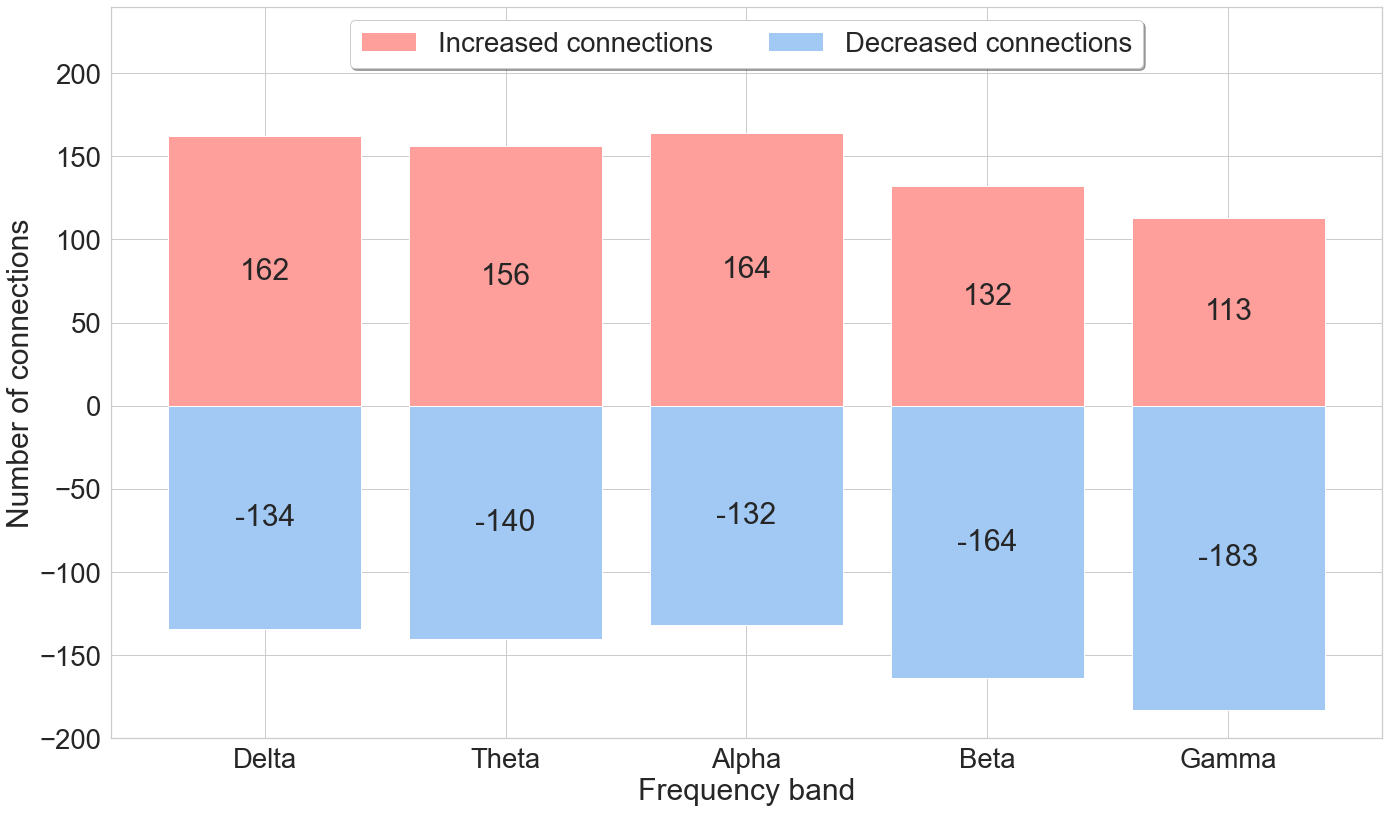

In [16]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=2.5)
# set figure size
fig, ax = plt.subplots(figsize=(20, 12))
sns.set_color_codes("pastel")
rect2 = plt.bar(df_change["freqs"], df_change['decrease'], color = "r", label = "Increased connections")
rect1 = plt.bar(df_change["freqs"], df_change['increase'], color = "b", label = "Decreased connections")
# rect2 = sns.barplot(data = df_change, x= "freqs", y='decrease', color = "b")
# sns.set_color_codes("muted")
# sns.barplot(data = df_change, x= "freqs", y='diff', color="r")
ax.bar_label(ax.containers[0], label_type='center')
ax.bar_label(ax.containers[1], label_type='center')

plt.ylabel("Number of connections")
plt.xlabel("Frequency band")
ax.set_ylim(-200, 240)

ax.set_xticklabels([v.capitalize() for v in freqs])
# put legend in the top middle
plt.legend(loc='upper center',
            ncol=2, fancybox=True, shadow=True)
plt.tight_layout()

In [17]:
# reorder the legend
lobe_order = ['Frontal', 'Insula', 'Temporal', 'Parietal', 'Occipital']
# colors = ["red", "lime", "blue", "yellow", "cyan"]
colors = np.array([(181,32,32), (221,147,27), (67,241,96), (65,92,214), (199,35,199)])/256

d_change_order = {}
for f in freqs:
    d_change_order[f] = [d_change[f][0], d_change[f][1]]
    d_change_order[f][0] = {k: d_change_order[f][0][k] for k in lobe_order}
    d_change_order[f][1] = {k: d_change_order[f][1][k] for k in lobe_order}

d_change_order


{'delta': [{'Frontal': 49,
   'Insula': 2,
   'Temporal': 30,
   'Parietal': 42,
   'Occipital': 11},
  {'Frontal': 71,
   'Insula': 5,
   'Temporal': 40,
   'Parietal': 32,
   'Occipital': 14}],
 'theta': [{'Frontal': 57,
   'Insula': 2,
   'Temporal': 33,
   'Parietal': 31,
   'Occipital': 17},
  {'Frontal': 48,
   'Insula': 0,
   'Temporal': 35,
   'Parietal': 54,
   'Occipital': 19}],
 'alpha': [{'Frontal': 45,
   'Insula': 3,
   'Temporal': 41,
   'Parietal': 30,
   'Occipital': 13},
  {'Frontal': 59,
   'Insula': 2,
   'Temporal': 36,
   'Parietal': 56,
   'Occipital': 11}],
 'beta': [{'Frontal': 51,
   'Insula': 3,
   'Temporal': 27,
   'Parietal': 69,
   'Occipital': 14},
  {'Frontal': 44,
   'Insula': 3,
   'Temporal': 39,
   'Parietal': 30,
   'Occipital': 16}],
 'gamma': [{'Frontal': 55,
   'Insula': 2,
   'Temporal': 58,
   'Parietal': 46,
   'Occipital': 22},
  {'Frontal': 56,
   'Insula': 2,
   'Temporal': 28,
   'Parietal': 14,
   'Occipital': 13}]}

In [24]:
d_inc = {k:v[1] for k,v in d_change_order.items()}
d_dec = {k:v[0] for k,v in d_change_order.items()}

df_inc = pd.DataFrame(d_inc)
df_dec = pd.DataFrame(d_dec)

c:\Users\work\Anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


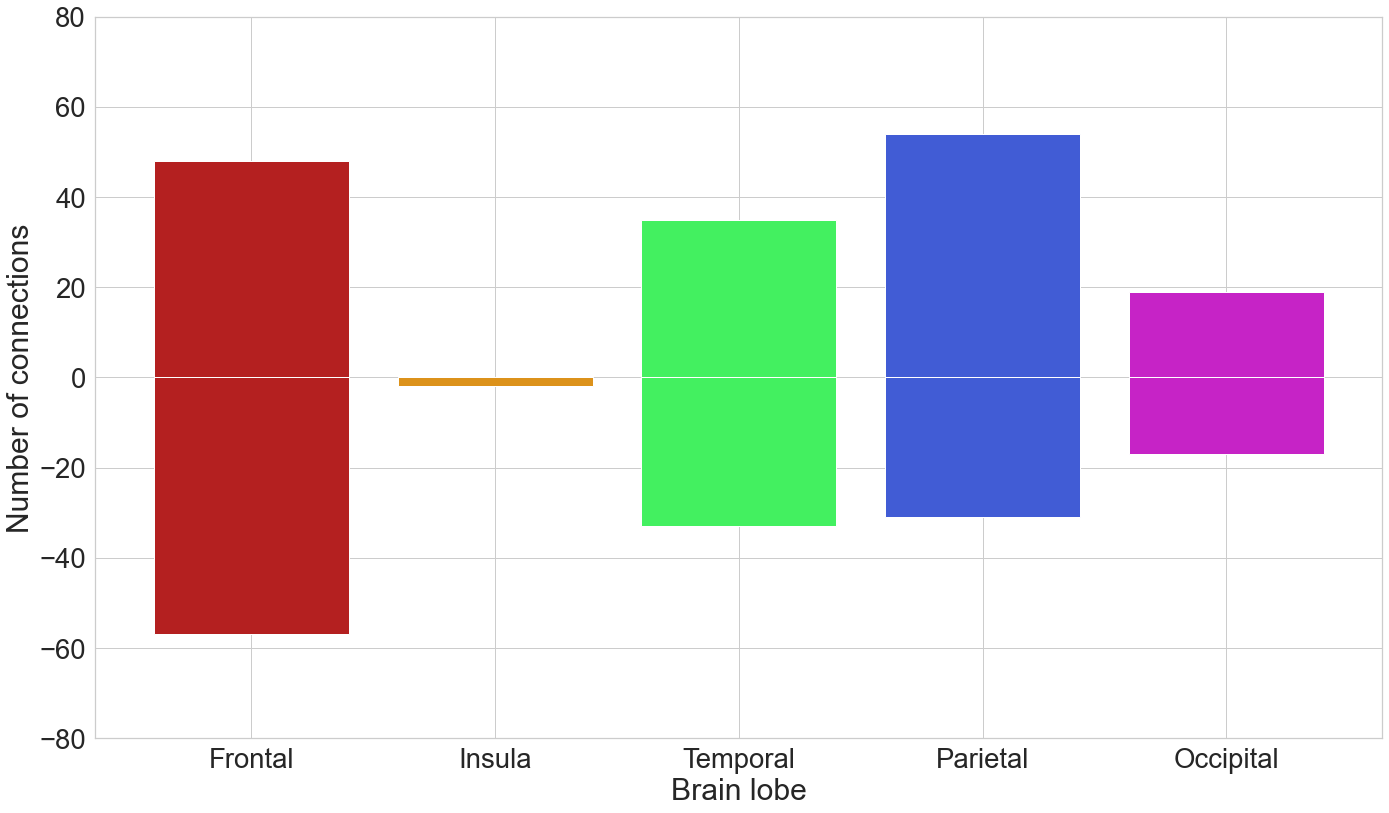

In [45]:
data = d_change_order['theta']

import seaborn as sns
sns.set(style="whitegrid", font_scale=2.5)
# set figure size
fig, ax = plt.subplots(figsize=(20, 12))

rect1 = plt.bar(lobe_order, np.array(list(data[1].values())), color = colors)
rect2 = plt.bar(lobe_order, np.array(list(data[0].values()))*-1, color = colors)
# rect2 = sns.barplot(data = df_change, x= "freqs", y='decrease', color = "b")
# sns.set_color_codes("muted")
# sns.barplot(data = df_change, x= "freqs", y='diff', color="r")
# ax.bar_label(ax.containers[0], label_type='center')
# ax.bar_label(ax.containers[1], label_type='center')

plt.ylabel("Number of connections")
plt.xlabel("Brain lobe")
ax.set_ylim(-80, 80)

ax.set_xticklabels([v.capitalize() for v in lobe_order])
# put legend in the top middle
plt.tight_layout()

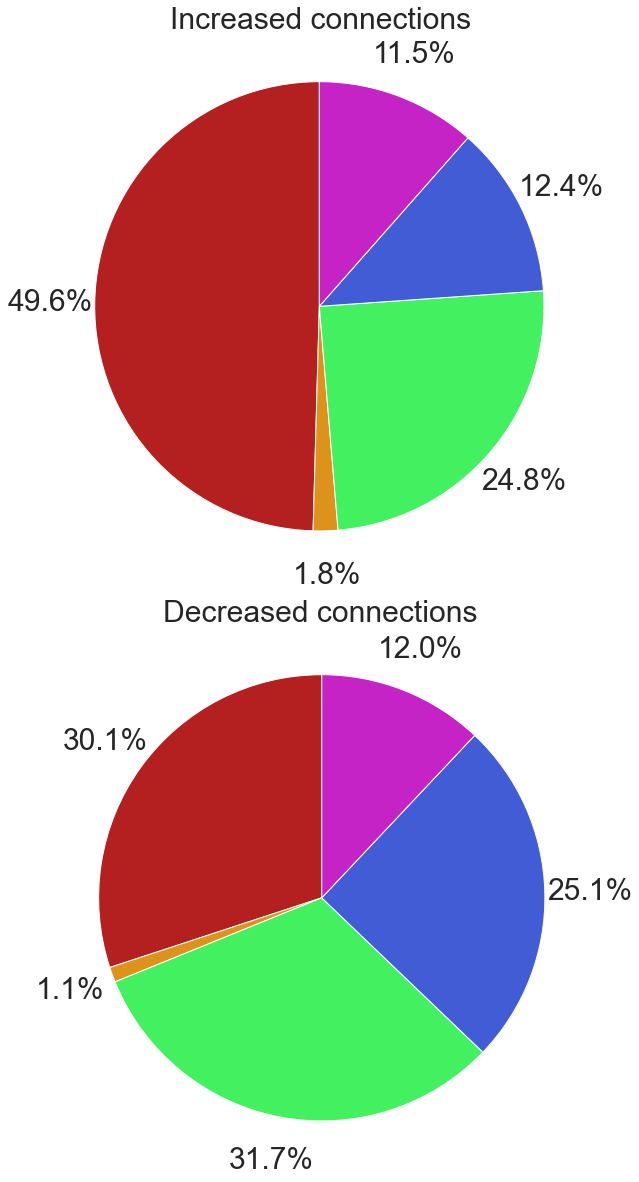

In [19]:
# matplotlib set colormap jet
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
sns.set(font_scale=2.5)

inc = d_change_order["gamma"][1]
dec = d_change_order["gamma"][0]
# plot pie chart
labels = list(inc.keys())
sizes = list(inc.values())
fig1, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
ax1.pie(sizes, autopct='%1.1f%%',startangle=90, pctdistance=1.2, labeldistance=1.2, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Increased connections", y=1.05)

labels = list(dec.keys())
sizes = list(dec.values())

ax2.pie(sizes, autopct='%1.1f%%', startangle=90, pctdistance=1.2, labeldistance=1.2, colors=colors)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("Decreased connections", y=1.05)
# plt.legend(labels, loc='best')
fig.tight_layout()

plt.show()

In [ ]:
69.9

In [405]:
data = np.load(f"connection_alter_beta.npy")

df_corr = pd.DataFrame(data, columns = label_names, index = label_names)
df_order = df_corr.reindex(new_order, axis=0).reindex(new_order, axis=1)

In [406]:
df_s =  df_order.stack().reset_index()
df_s.columns = ['source', 'target', 'connectivity']
df_s = df_s[df_s['connectivity']!=0].reset_index()

In [407]:
lobe_name = ['Frontal-rh', 'Insula-rh','Temporal-rh', 'Parietal-rh', 'Occipital-rh',
             'Occipital-lh', 'Parietal-lh','Temporal-lh', 'Insula-lh',  'Frontal-lh',]

In [408]:
# d_count_intra_dec = {k:0 for k in lobe_name}
# d_count_intra_inc = {k:0 for k in lobe_name}
d_count_inter_dec = {k:{j:0 for j in lobe_name} for k in lobe_name}
d_count_inter_inc = {k:{j:0 for j in lobe_name} for k in lobe_name}
for i in range(len(df_s)):
    source = df_s['source'][i]
    target = df_s['target'][i]
    val = df_s['connectivity'][i]
    source_lobe, hemisphere1 = get_lobe(source)
    target_lobe, hemisphere2 = get_lobe(target)
    s = source_lobe + "-" + hemisphere1
    t = target_lobe + "-" + hemisphere2

    # if s == t:
    #     if val < 0:
    #         d_count_intra_inc[s] += 1
    #     else:
    #         d_count_intra_dec[s] += 1
    # else:
    if val < 0:
        if d_count_inter_inc[s].get(t):
            d_count_inter_inc[s][t] += 1
        else:
            d_count_inter_inc[s][t] = 1
    else:
        if d_count_inter_dec[s].get(t):
            d_count_inter_dec[s][t] += 1
        else:
            d_count_inter_dec[s][t] = 1


In [409]:
d_count_inter_dec_2 = {k:{j:0 for j in lobe_name} for k in lobe_name}
for i in d_count_inter_dec:
    for j in d_count_inter_dec[i]:
        d_count_inter_dec_2[i][j] = d_count_inter_dec[i][j] + d_count_inter_dec[j][i]

d_count_inter_inc_2 = {k:{j:0 for j in lobe_name} for k in lobe_name}
for i in d_count_inter_inc:
    for j in d_count_inter_inc[i]:
        d_count_inter_inc_2[i][j] = d_count_inter_inc[i][j] + d_count_inter_inc[j][i]

In [410]:
# d_count_intra_dec = {k:0 for k in lobe_name}
# d_count_intra_inc = {k:0 for k in lobe_name}
d_count_inter_dec_3 = {k:{j:0 for j in lobe_map.keys()} for k in lobe_map.keys()}
d_count_inter_inc_3 = {k:{j:0 for j in lobe_map.keys()} for k in lobe_map.keys()}
for i in range(len(df_s)):
    source = df_s['source'][i]
    target = df_s['target'][i]
    val = df_s['connectivity'][i]
    source_lobe, hemisphere1 = get_lobe(source)
    target_lobe, hemisphere2 = get_lobe(target)
    s = source_lobe 
    t = target_lobe

    if val < 0:
        if d_count_inter_inc_3[s].get(t):
            d_count_inter_inc_3[s][t] += 1
        else:
            d_count_inter_inc_3[s][t] = 1
    else:
        if d_count_inter_dec_3[s].get(t):
            d_count_inter_dec_3[s][t] += 1
        else:
            d_count_inter_dec_3[s][t] = 1


In [411]:
intra_inc = {k:0 for k in lobe_map.keys()}
inter_inc = {k:0 for k in lobe_map.keys()}
for i in d_count_inter_inc_3:
    for j in d_count_inter_inc_3[i]:
        if i == j:
            intra_inc[i] += d_count_inter_inc_3[i][j]
        else:
            inter_inc[i] += d_count_inter_inc_3[i][j]

intra_dec = {k:0 for k in lobe_map.keys()}
inter_dec = {k:0 for k in lobe_map.keys()}
for i in d_count_inter_dec_3:
    for j in d_count_inter_dec_3[i]:
        if i == j:
            intra_dec[i] += d_count_inter_dec_3[i][j]
        else:
            inter_dec[i] += d_count_inter_dec_3[i][j]

In [412]:
inter_inc

{'Frontal': 21, 'Parietal': 27, 'Temporal': 25, 'Occipital': 15, 'Insula': 3}

In [413]:
inter_dec

{'Frontal': 31, 'Parietal': 54, 'Temporal': 26, 'Occipital': 14, 'Insula': 2}

In [414]:
sum(inter_dec.values())/(sum(inter_dec.values())+sum(intra_dec.values()))

0.774390243902439

In [415]:
intra_inc

{'Frontal': 23, 'Parietal': 3, 'Temporal': 14, 'Occipital': 1, 'Insula': 0}

In [404]:
intra_inc["Frontal"]/sum(intra_inc.values())

0.4318181818181818

In [358]:
intra_dec

{'Frontal': 20, 'Parietal': 15, 'Temporal': 1, 'Occipital': 0, 'Insula': 1}

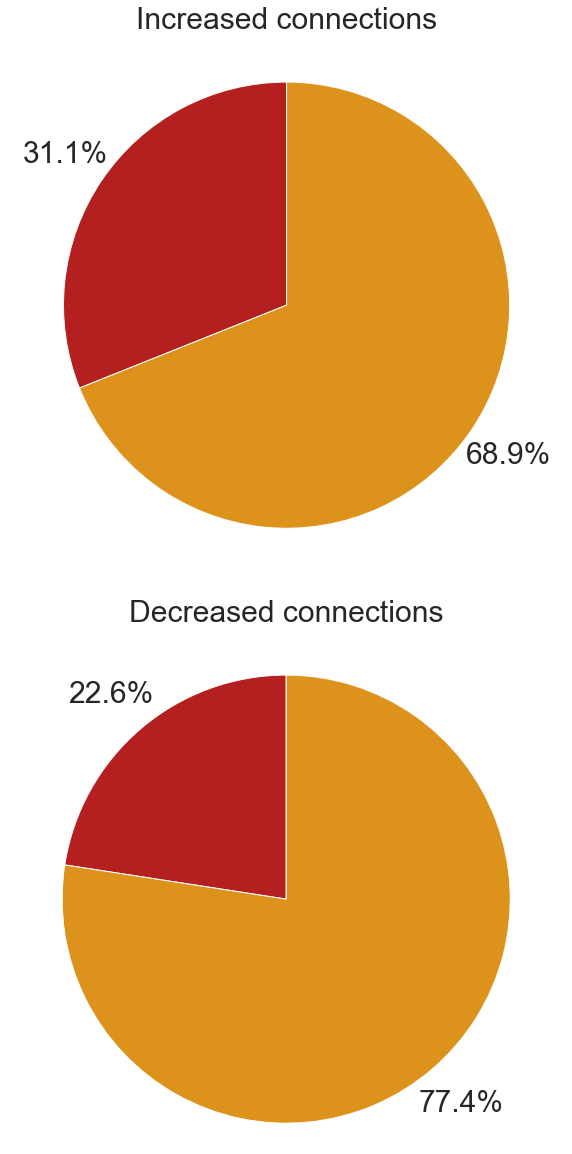

In [311]:
sns.set(font_scale=2.5)

# plot pie chart
labels = ["Intra-connections", "Inter-connections"]
sizes = [sum(intra_inc.values()), sum(inter_inc.values())]
fig1, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
ax1.pie(sizes, autopct='%1.1f%%',startangle=90, pctdistance=1.2, labeldistance=1.2, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Increased connections", y=1.05)

labels = ["Intra-connections", "Inter-connections"]
sizes = [sum(intra_dec.values()), sum(inter_dec.values())]

ax2.pie(sizes, autopct='%1.1f%%', startangle=90, pctdistance=1.2, labeldistance=1.2, colors=colors)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("Decreased connections", y=1.05)
# plt.legend(labels, loc='best')
fig.tight_layout()
# fig.savefig("pie.png", dpi=300)
plt.show()

In [312]:
# substract 2 dicts
d_count_sum = {k:{j: d_count_inter_dec[k][j] + d_count_inter_inc[k][j] for j in lobe_name} for k in lobe_name}
d_count_diff = {k:{j: d_count_inter_dec[k][j] - d_count_inter_inc[k][j] for j in lobe_name} for k in lobe_name}

In [36]:
d_count_sum_2 = {k:{j: d_count_inter_dec_2[k][j] + d_count_inter_inc_2[k][j] for j in lobe_name} for k in lobe_name}
d_count_diff_2 = {k:{j: d_count_inter_dec_2[k][j] - d_count_inter_inc_2[k][j] for j in lobe_name} for k in lobe_name}

In [67]:
pd.DataFrame(d_count_diff)

,Frontal-rh,Insula-rh,Temporal-rh,Parietal-rh,Occipital-rh,Occipital-lh,Parietal-lh,Temporal-lh,Insula-lh,Frontal-lh
Frontal-rh,1,0,-3,4,-1,-1,4,0,0,-3
Insula-rh,0,0,0,2,0,0,0,-1,0,-1
Temporal-rh,-9,-1,-1,0,0,2,-1,-7,-2,-3
Parietal-rh,3,0,-1,-1,0,0,4,2,0,-3
Occipital-rh,-2,0,2,-1,0,-1,0,0,0,0
Occipital-lh,-2,0,2,0,-2,-3,0,1,0,-1
Parietal-lh,5,0,2,3,0,0,1,2,1,1
Temporal-lh,0,-1,6,2,2,1,3,-4,1,-3
Insula-lh,-3,-1,-1,0,0,0,0,-1,0,0
Frontal-lh,6,0,-6,-8,-1,1,-2,-2,0,-8


In [40]:
# get the values of the diagonal
d_count_diag = {k:d_count_diff_2[k][k] for k in lobe_name}
d_count_diag

{'Frontal-rh': 2,
 'Insula-rh': 0,
 'Temporal-rh': -2,
 'Parietal-rh': -2,
 'Occipital-rh': 0,
 'Occipital-lh': -6,
 'Parietal-lh': 2,
 'Temporal-lh': -8,
 'Insula-lh': 0,
 'Frontal-lh': -16}

'\ndelta: frontal: 0.40540540540540543, insula: 0.02364864864864865, temporal: 0.23648648648648649, parietal: 0.25, occipital: 0.08445945945945946\n\ntheta: frontal: 0.3547297297297297, insula: 0.006756756756756757, temporal: 0.22972972972972974, parietal: 0.28716216216216217, occipital: 0.12162162162162163\n\nalpha: frontal: 0.35135135135135137, insula: 0.016891891891891893, temporal: 0.26013513513513514, parietal: 0.2905405405405405, occipital: 0.08108108108108109\n\nbeta: frontal: 0.32094594594594594, insula: 0.02027027027027027, temporal: 0.22297297297297297, parietal: 0.3344594594594595, occipital: 0.10135135135135136\n\ngamma: frontal: 0.375, insula: 0.013513513513513514, temporal: 0.2905405405405405, parietal: 0.20270270270270271, occipital: 0.11824324324324324\n\n'

In [30]:
pd.DataFrame(d_count_sum)

,Frontal-rh,Insula-rh,Temporal-rh,Parietal-rh,Occipital-rh,Occipital-lh,Parietal-lh,Temporal-lh,Insula-lh,Frontal-lh
Frontal-rh,8,1,6,8,3,1,12,7,0,10
Insula-rh,0,0,0,0,0,0,0,0,0,1
Temporal-rh,4,0,2,5,3,2,3,4,1,5
Parietal-rh,3,0,2,7,2,3,5,4,0,8
Occipital-rh,3,0,2,5,0,1,6,1,0,2
Occipital-lh,4,0,4,4,0,0,5,1,0,4
Parietal-lh,3,0,4,4,2,2,2,2,0,2
Temporal-lh,5,0,3,4,2,3,7,6,2,6
Insula-lh,0,1,0,1,0,0,1,3,0,2
Frontal-lh,15,1,7,10,1,5,10,8,0,10


In [31]:
d_count_sum = pd.DataFrame(d_count_sum)
d_count_diff = pd.DataFrame(d_count_diff)
# get absolute value
d_count_sum.to_csv("d_count_sum.csv", sep=" ")

In [32]:
d_count_sum_2 = pd.DataFrame(d_count_sum_2)
d_count_diff_2 = pd.DataFrame(d_count_diff_2)
# get absolute value
# d_count_sum_2.to_csv("d_count_sum_2.csv", sep=" ")

In [33]:
d_count_sum_2.sum(axis=1)

Frontal-rh      101
Insula-rh         4
Temporal-rh      59
Parietal-rh      82
Occipital-rh     33
Occipital-lh     39
Parietal-lh      72
Temporal-lh      74
Insula-lh        11
Frontal-lh      117
dtype: int64

In [34]:
109/295

0.3694915254237288

In [35]:
(4+11)/2

7.5

In [36]:
d_count_diff_2

,Frontal-rh,Insula-rh,Temporal-rh,Parietal-rh,Occipital-rh,Occipital-lh,Parietal-lh,Temporal-lh,Insula-lh,Frontal-lh
Frontal-rh,16,1,4,-1,4,1,5,6,0,-9
Insula-rh,1,0,0,0,0,0,0,0,1,-2
Temporal-rh,4,0,-4,-1,5,0,3,-5,1,-4
Parietal-rh,-1,0,-1,10,-3,3,9,2,1,6
Occipital-rh,4,0,5,-3,0,-1,2,-3,0,3
Occipital-lh,1,0,0,3,-1,0,1,-4,0,3
Parietal-lh,5,0,3,9,2,1,-4,3,-1,-2
Temporal-lh,6,0,-5,2,-3,-4,3,-12,-3,4
Insula-lh,0,1,1,1,0,0,-1,-3,0,2
Frontal-lh,-9,-2,-4,6,3,3,-2,4,2,-4


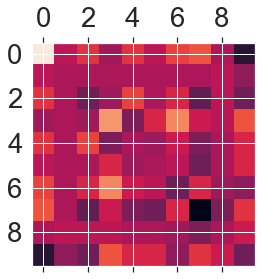

In [42]:
#plot correlation matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
plt.matshow(d_count_diff_2)



In [ ]:
#set upper triangle to zero
d_count_sum_2.where(np.tril(np.ones(d_count_sum_2.shape)).astype(np.bool)).fillna(0).astype(int).to_csv("d_count_sum_2.csv", sep=" ")
d_count_diff_2.where(np.tril(np.ones(d_count_diff_2.shape)).astype(np.bool)).fillna(0).astype(int).to_csv("d_count_diff_2.csv")


c:\Users\work\Anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
c:\Users\work\Anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
d_count_diff.to_csv("d_count_diff.csv")

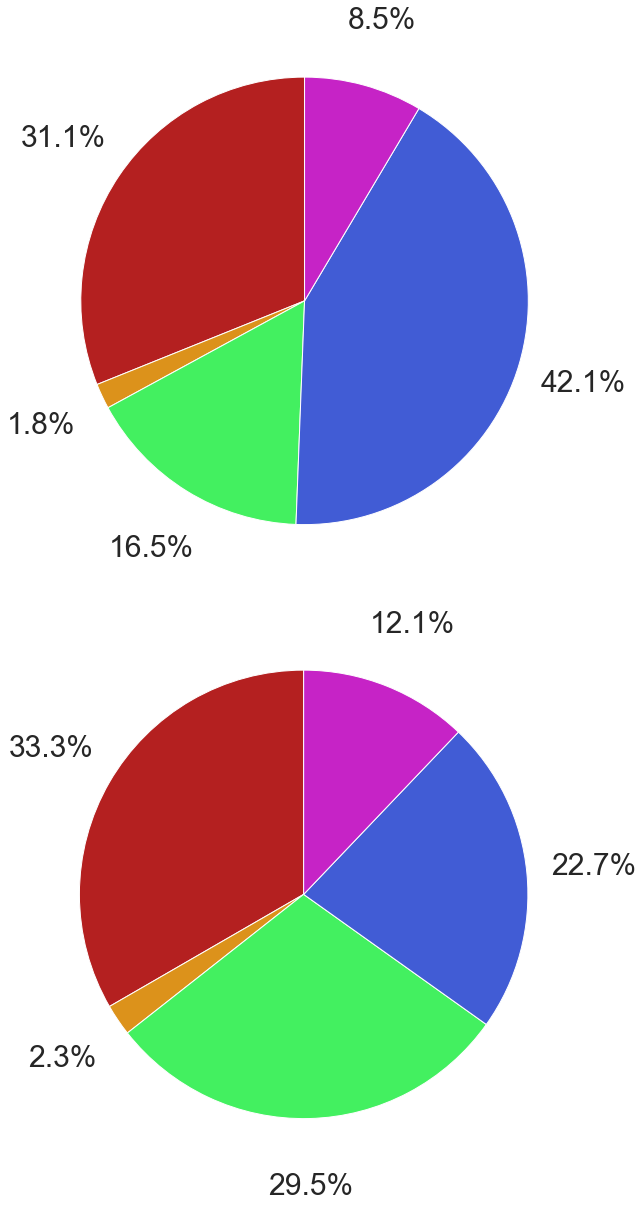

In [ ]:
colors = np.array([(181,32,32), (221,147,27), (67,241,96), (65,92,214), (199,35,199)])/256
# add alpha
colors = np.hstack((colors, np.ones((5,1))))
# matplotlib set colormap jet
sns.set(font_scale=2.5)

inc = d_change_order["beta"][0]
dec = d_change_order["beta"][1]
# plot pie chart
labels = list(inc.keys())
sizes = list(inc.values())
fig1, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
ax1.pie(sizes, autopct='%1.1f%%',startangle=90, pctdistance=1.3, labeldistance=1.2, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# ax1.set_title("increased connections")

labels = list(dec.keys())
sizes = list(dec.values())

ax2.pie(sizes, autopct='%1.1f%%', startangle=90, pctdistance=1.3, labeldistance=1.2, colors=colors)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# ax2.set_title("decreased connections")
# plt.legend(labels, loc='right')
fig.tight_layout()

plt.show()

In [ ]:
df_pair = df_corr.stack().reset_index()

In [ ]:
df_pair.columns = ['source', 'target', 'connectivity']
df_pair.head()

,source,target,connectivity
0,bankssts-lh,bankssts-lh,0.000000
1,bankssts-lh,bankssts-rh,0.000000
2,bankssts-lh,caudalanteriorcingulate-lh,0.000000
3,bankssts-lh,caudalanteriorcingulate-rh,0.135901
4,bankssts-lh,caudalmiddlefrontal-lh,0.000000


In [ ]:
df_order = df_pair.set_index(['source', 'target']).reindex(new_order, level=0).reindex(new_order, level=1).reset_index()
df_order

,source,target,connectivity
0,frontalpole-lh,frontalpole-lh,0.0
1,frontalpole-lh,rostralmiddlefrontal-lh,0.0
2,frontalpole-lh,parsorbitalis-lh,0.0
3,frontalpole-lh,medialorbitofrontal-lh,0.0
4,frontalpole-lh,rostralanteriorcingulate-lh,0.0
...,...,...,...
4619,frontalpole-rh,rostralanteriorcingulate-rh,0.0
4620,frontalpole-rh,medialorbitofrontal-rh,0.0
4621,frontalpole-rh,parsorbitalis-rh,0.0
4622,frontalpole-rh,rostralmiddlefrontal-rh,0.0
